## Preprocessing Videos for Multimodal RAG 

## Setup

In [5]:
%pip install moviepy
%pip install pytube youtube-transcript-api
from pathlib import Path
import os
from os import path as osp
import json
import cv2
import webvtt
import whisper
from moviepy import VideoFileClip
from PIL import Image
import base64
from pytube import YouTube
from yt_dlp import YoutubeDL
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Download Video Corpuses

In [25]:
from yt_dlp import YoutubeDL
import os

def download_video(url: str, output_dir: str) -> str:
    """
    Download the best MP4 from a YouTube URL into output_dir using yt-dlp.
    Returns the local filepath.
    """
    os.makedirs(output_dir, exist_ok=True)

    ydl_opts = {
        "format": "bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]",
        "outtmpl": os.path.join(output_dir, "%(id)s.%(ext)s"),
        "merge_output_format": "mp4",
        "quiet": True,  # remove if you want progress logs
    }
    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)
        vid_id = info["id"]
        ext    = info.get("ext", "mp4")
        filepath = os.path.join(output_dir, f"{vid_id}.{ext}")
        if not os.path.isfile(filepath):
            raise FileNotFoundError(f"Expected video at {filepath} but none found.")
        return filepath



def get_transcript_vtt(url: str, output_dir: str) -> str:
    """
    Download English subtitles (manual or auto-generated) as .vtt using yt-dlp.
    Returns the path to the saved .vtt file.
    """
    os.makedirs(output_dir, exist_ok=True)

    ydl_opts = {
        'skip_download': True,
        'writesubtitles': True,        # get manually uploaded subs
        'writeautomaticsub': True,     # also get auto-generated subs
        'subtitleslangs': ['en'],
        'subtitlesformat': 'vtt',
        'outtmpl': os.path.join(output_dir, '%(id)s.%(ext)s'),
        'quiet': True,
    }

    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)
        video_id = info['id']

    # yt-dlp may emit files named:
    #   {video_id}.vtt
    #   {video_id}.en.vtt
    #   {video_id}.en.vtt  (duplicate patterns)
    candidates = [
        os.path.join(output_dir, f"{video_id}.vtt"),
        os.path.join(output_dir, f"{video_id}.en.vtt"),
    ]
    for path in candidates:
        if os.path.isfile(path):
            return path

    raise FileNotFoundError(f"No VTT subtitle found in {output_dir} for ID {video_id}")

In [26]:
url      = "https://www.youtube.com/watch?v=7Hcg-rLYwdM"
out_dir  = "./shared_data/videos/video1"

# 1) Test download_video
try:
    vid1_filepath = download_video(url, out_dir)
    print("✅ download_video succeeded. File at:", vid1_filepath)
except Exception as e:
    print("❌ download_video failed with:", repr(e))

# 2) Test get_transcript_vtt
try:
    vid1_transcript_filepath = get_transcript_vtt(url, out_dir)
    print("✅ get_transcript_vtt succeeded. File at:", vid1_transcript_filepath)
except Exception as e:
    print("❌ get_transcript_vtt failed with:", repr(e))


✅ download_video succeeded. File at: ./shared_data/videos/video1/7Hcg-rLYwdM.mp4
✅ get_transcript_vtt succeeded. File at: ./shared_data/videos/video1/7Hcg-rLYwdM.en.vtt


In [27]:
# show the paths to video1 and its transcription
print(vid1_filepath)
print(vid1_transcript_filepath)

./shared_data/videos/video1/7Hcg-rLYwdM.mp4
./shared_data/videos/video1/7Hcg-rLYwdM.en.vtt


In [28]:
!head -n15 {vid1_transcript_filepath}

WEBVTT
Kind: captions
Language: en

00:00:03.620 --> 00:00:06.879
As I look back on the the mission that we've had here

00:00:06.879 --> 00:00:10.559
on the International Space Station,
I'm proud to have been a part of much of

00:00:10.559 --> 00:00:13.679
the science activities that happened over the last

00:00:13.680 --> 00:00:14.420


### Helper functions

In [35]:
import re
from PIL import Image

def str2time(timestr: str) -> int:
    """
    Convert a time string “HH:MM:SS.sss” or “MM:SS.sss” into milliseconds.
    """
    # Matches optional hours, mandatory minutes, seconds(.ms)
    m = re.match(r'(?:(\d+):)?(\d+):(\d+(?:\.\d+)?)', timestr)
    if not m:
        raise ValueError(f"Invalid time format: {timestr!r}")
    hours   = int(m.group(1)) if m.group(1) else 0
    minutes = int(m.group(2))
    seconds = float(m.group(3))
    total_ms = int((hours * 3600 + minutes * 60 + seconds) * 1000)
    return total_ms

from PIL import Image

def maintain_aspect_ratio_resize(
    image: Image.Image, *, width: int = None, height: int = None
) -> Image.Image:
    """
    Resize a PIL Image to either a given width or height (or both)
    while preserving the aspect ratio.
    """
    orig_w, orig_h = image.size

    if width and height:
        scale = min(width / orig_w, height / orig_h)
        new_w, new_h = int(orig_w * scale), int(orig_h * scale)
    elif width:
        scale = width / orig_w
        new_w, new_h = width, int(orig_h * scale)
    elif height:
        scale = height / orig_h
        new_w, new_h = int(orig_w * scale), height
    else:
        return image  # no resizing needed

    # Use the high-quality LANCZOS resampler
    try:
        resample_filter = Image.Resampling.LANCZOS
    except AttributeError:
        # Fallback for older Pillow versions
        resample_filter = Image.LANCZOS

    return image.resize((new_w, new_h), resample=resample_filter)



## 1. Video Corpus and Its Transcript Are Available

In [38]:
def extract_and_save_frames_and_metadata(
        path_to_video, 
        path_to_transcript, 
        path_to_save_extracted_frames,
        path_to_save_metadatas):

    metadatas = []
    video  = cv2.VideoCapture(path_to_video)
    trans  = webvtt.read(path_to_transcript)

    for idx, cue in enumerate(trans):
        start_ms = str2time(cue.start)
        end_ms   = str2time(cue.end)
        mid_ms   = (start_ms + end_ms) / 2
        text     = cue.text.replace("\n", " ")

        video.set(cv2.CAP_PROP_POS_MSEC, mid_ms)
        success, frame = video.read()
        if not success:
            print(f"ERROR! Cannot extract frame: idx = {idx}")
            continue

        # 1) Convert BGR array -> RGB PIL Image
        pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # 2) Resize with aspect ratio (your helper)
        pil_resized = maintain_aspect_ratio_resize(pil_img, height=350)

        # 3) Convert back to BGR NumPy for cv2.imwrite
        bgr_resized = cv2.cvtColor(np.array(pil_resized), cv2.COLOR_RGB2BGR)

        # 4) Save
        img_fname = f"frame_{idx}.jpg"
        img_fpath = os.path.join(path_to_save_extracted_frames, img_fname)
        cv2.imwrite(img_fpath, bgr_resized)

        metadatas.append({
            "extracted_frame_path": img_fpath,
            "transcript":           text,
            "video_segment_id":     idx,
            "video_path":           path_to_video,
            "mid_time_ms":          mid_ms,
        })

    # persist metadata list
    fn = os.path.join(path_to_save_metadatas, "metadatas.json")
    with open(fn, "w", encoding="utf-8") as f:
        json.dump(metadatas, f, indent=2)

    return metadatas

In [39]:
# output paths to save extracted frames and their metadata 
extracted_frames_path = osp.join(vid1_dir, 'extracted_frame')
metadatas_path = vid1_dir

# create these output folders if not existing
Path(extracted_frames_path).mkdir(parents=True, exist_ok=True)
Path(metadatas_path).mkdir(parents=True, exist_ok=True)

# call the function to extract frames and metadatas
metadatas = extract_and_save_frames_and_metadata(
                vid1_filepath, 
                vid1_transcript_filepath,
                extracted_frames_path,
                metadatas_path,
            )                     

In [40]:
metadatas[:4]

[{'extracted_frame_path': './shared_data/videos/video1/extracted_frame/frame_0.jpg',
  'transcript': "As I look back on the the mission that we've had here",
  'video_segment_id': 0,
  'video_path': './shared_data/videos/video1/7Hcg-rLYwdM.mp4',
  'mid_time_ms': 5249.5},
 {'extracted_frame_path': './shared_data/videos/video1/extracted_frame/frame_1.jpg',
  'transcript': "on the International Space Station, I'm proud to have been a part of much of",
  'video_segment_id': 1,
  'video_path': './shared_data/videos/video1/7Hcg-rLYwdM.mp4',
  'mid_time_ms': 8719.0},
 {'extracted_frame_path': './shared_data/videos/video1/extracted_frame/frame_2.jpg',
  'transcript': 'the science activities that happened over the last',
  'video_segment_id': 2,
  'video_path': './shared_data/videos/video1/7Hcg-rLYwdM.mp4',
  'mid_time_ms': 12119.0},
 {'extracted_frame_path': './shared_data/videos/video1/extracted_frame/frame_3.jpg',
  'transcript': 'two months.',
  'video_segment_id': 3,
  'video_path': './sha

### Extract Frames and Metadata for Videos Using LVLM Inference

In [17]:
# function extract_and_save_frames_and_metadata_with_fps
#   receives as input a video 
#   does extracting and saving frames and their metadatas
#   returns the extracted metadatas
def extract_and_save_frames_and_metadata_with_fps(
        path_to_video,  
        path_to_save_extracted_frames,
        path_to_save_metadatas,
        num_of_extracted_frames_per_second=1):
    
    # metadatas will store the metadata of all extracted frames
    metadatas = []

    # load video using cv2
    video = cv2.VideoCapture(path_to_video)
    
    # Get the frames per second
    fps = video.get(cv2.CAP_PROP_FPS)
    # Get hop = the number of frames pass before a frame is extracted
    hop = round(fps / num_of_extracted_frames_per_second) 
    curr_frame = 0
    idx = -1
    while(True):
        # iterate all frames
        ret, frame = video.read()
        if not ret: 
            break
        if curr_frame % hop == 0:
            idx = idx + 1
        
            # if the frame is extracted successfully, resize it
            image = maintain_aspect_ratio_resize(frame, height=350)
            # save frame as JPEG file
            img_fname = f'frame_{idx}.jpg'
            img_fpath = osp.join(
                            path_to_save_extracted_frames, 
                            img_fname
                        )
            cv2.imwrite(img_fpath, image)

            # generate caption using lvlm_inference
            b64_image = encode_image(img_fpath)
            caption = lvlm_inference(lvlm_prompt, b64_image)
                
            # prepare the metadata
            metadata = {
                'extracted_frame_path': img_fpath,
                'transcript': caption,
                'video_segment_id': idx,
                'video_path': path_to_video,
            }
            metadatas.append(metadata)
        curr_frame += 1
        
    # save metadata of all extracted frames
    metadatas_path = osp.join(path_to_save_metadatas,'metadatas.json')
    with open(metadatas_path, 'w') as outfile:
        json.dump(metadatas, outfile)
    return metadatas

In [18]:
# paths to save extracted frames and metadata (their transcripts)
extracted_frames_path = osp.join(vid2_dir, 'extracted_frame')
metadatas_path = vid2_dir

# create these output folders if not existing
Path(extracted_frames_path).mkdir(parents=True, exist_ok=True)
Path(metadatas_path).mkdir(parents=True, exist_ok=True)

# call the function to extract frames and metadatas
metadatas = extract_and_save_frames_and_metadata_with_fps(
                vid2_filepath, 
                extracted_frames_path,
                metadatas_path,
                num_of_extracted_frames_per_second=0.1
            )

Generated caption is: "The image features a young boy walking on a playground, holding a water bottle in his hand. He is wearing a blue shirt and appears to be enjoying his time at the park. The playground has a bench nearby, providing a place for the boy to sit and relax. The scene captures the essence of a typical day at the park for a young child."


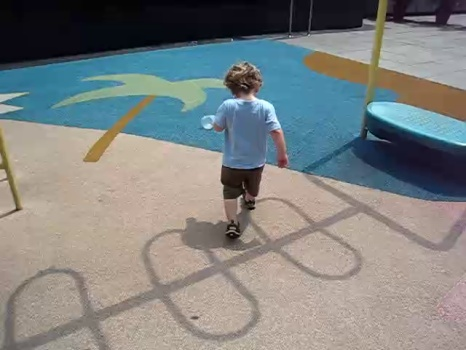

In [19]:
data = metadatas[1]
caption = data['transcript']
print(f'Generated caption is: "{caption}"')
frame = Image.open(data['extracted_frame_path'])
display(frame)